In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
import itertools

import time

# used to supress display of warnings
import warnings

# ols library
import statsmodels.api as sm
import statsmodels.formula.api as smf

import missingno as mno
from sklearn.cluster import DBSCAN
from sklearn.cluster import OPTICS

# import zscore for scaling the data
from scipy.stats import zscore
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer, RobustScaler, LabelEncoder

from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

# pre-processing methods
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures

from sklearn.compose import TransformedTargetRegressor

# the regression models 
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge,Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor

# cross-validation methods
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn import metrics

from sklearn.pipeline import Pipeline

# feature-selection methods
from sklearn.feature_selection import SelectFromModel

# bootstrap sampling
from sklearn.utils import resample

In [3]:
df = pd.read_csv("diamonds.csv")
df.head()

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  53940 non-null  int64  
 1   carat       53940 non-null  float64
 2   cut         53940 non-null  object 
 3   color       53940 non-null  object 
 4   clarity     53940 non-null  object 
 5   depth       53940 non-null  float64
 6   table       53940 non-null  float64
 7   price       53940 non-null  int64  
 8   x           53940 non-null  float64
 9   y           53940 non-null  float64
 10  z           53940 non-null  float64
dtypes: float64(6), int64(2), object(3)
memory usage: 4.5+ MB


In [6]:
data = df.drop(["Unnamed: 0"], axis=1)
data.describe()

,carat,depth,table,price,x,y,z
count,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000
mean,0.797940,61.749405,57.457184,3932.799722,5.731157,5.734526,3.538734
std,0.474011,1.432621,2.234491,3989.439738,1.121761,1.142135,0.705699
min,0.200000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,0.400000,61.000000,56.000000,950.000000,4.710000,4.720000,2.910000
50%,0.700000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000
75%,1.040000,62.500000,59.000000,5324.250000,6.540000,6.540000,4.040000
max,5.010000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000


In [7]:
#Dropping dimentionless diamonds
data = data.drop(data[data["x"]==0].index)
data = data.drop(data[data["y"]==0].index)
data = data.drop(data[data["z"]==0].index)
data.shape

(53920, 10)

(53907, 10)

In [9]:
s = (data.dtypes =="object")
object_cols = list(s[s].index)
print("Categorical variables:")
print(object_cols)

Categorical variables:
['cut', 'color', 'clarity']


In [19]:
label_data = data.copy()

# Apply label encoder to each column with categorical data
label_encoder = LabelEncoder()
for col in object_cols:
    label_data[col] = label_encoder.fit_transform(label_data[col])
label_data.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,2,1,3,61.5,55.0,326,3.95,3.98,2.43
1,0.21,3,1,2,59.8,61.0,326,3.89,3.84,2.31
2,0.23,1,1,4,56.9,65.0,327,4.05,4.07,2.31
3,0.29,3,5,5,62.4,58.0,334,4.20,4.23,2.63
4,0.31,1,6,3,63.3,58.0,335,4.34,4.35,2.75


In [20]:
#check duplicates
label_data.duplicated().sum()

0

In [22]:
duplicates = label_data.duplicated()

label_data[duplicates]

,carat,cut,color,clarity,depth,table,price,x,y,z


In [17]:
# Delete duplicate rows
label_data.drop_duplicates(inplace=True)

<Axes: >

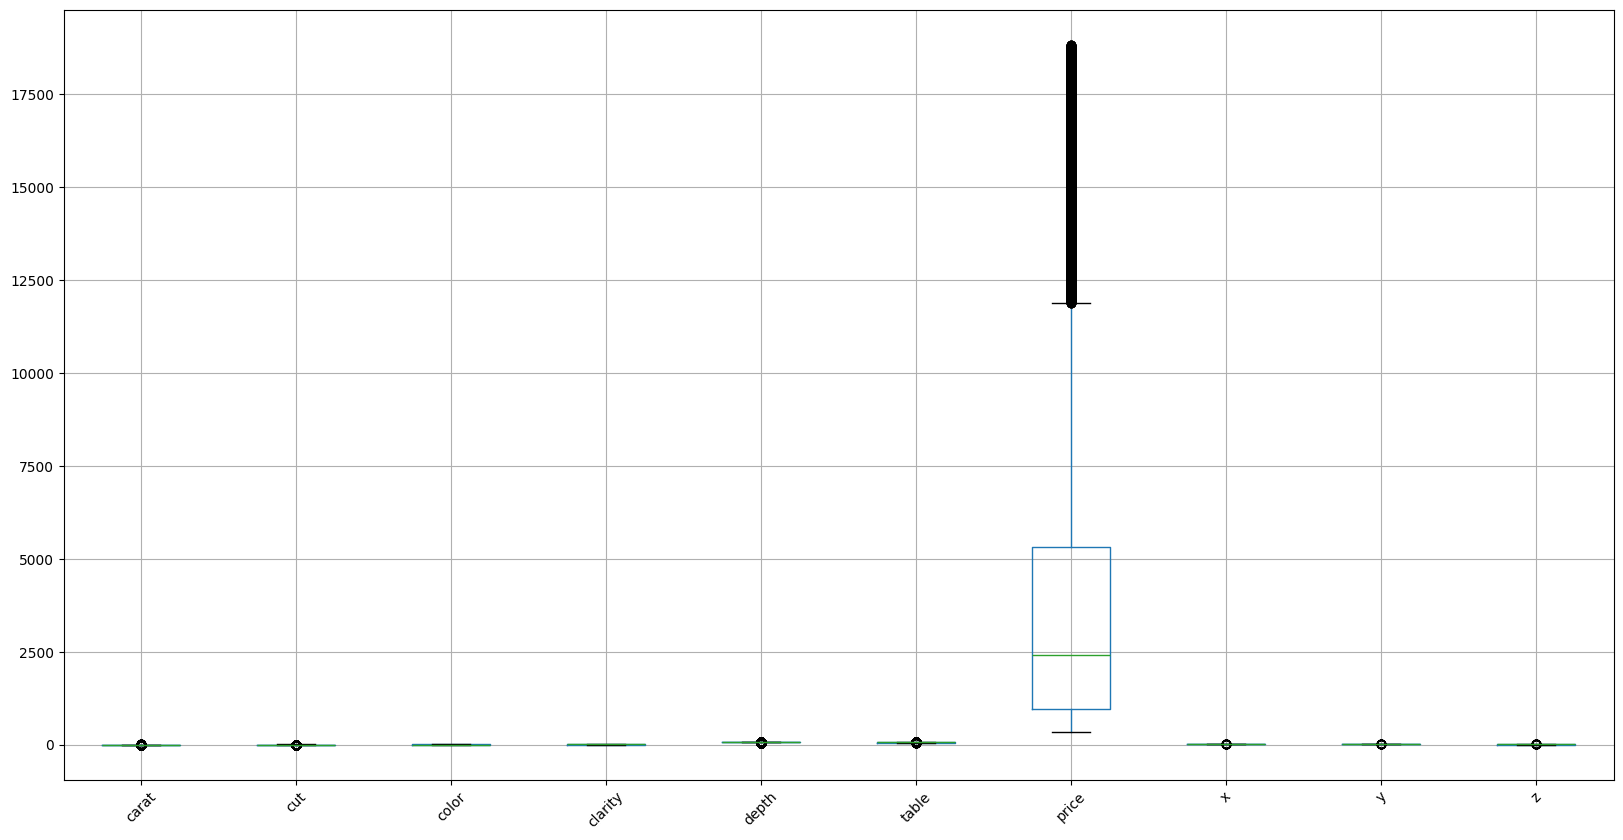

In [26]:

label_data.boxplot(column = ['carat', 'cut', 'color', 'clarity', 'depth', 'table',
       'price', 'x', 'y', 'z'], rot=45, figsize = (20,10))

In [28]:
label_data.isnull().sum()

carat      0
cut        0
color      0
clarity    0
depth      0
table      0
price      0
x          0
y          0
z          0
dtype: int64

In [30]:
# Assigning the featurs as X and trarget as y
X= label_data.drop(["price"],axis =1)
y= label_data["price"]
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.30, random_state=1)

In [31]:
print('X_train shape : ({0},{1})'.format(X_train.shape[0], X_train.shape[1]))
print('y_train shape : ({0},)'.format(y_train.shape[0]))
print('X_test shape : ({0},{1})'.format(X_test.shape[0], X_test.shape[1]))
print('y_test shape : ({0},)'.format(y_test.shape[0]))

X_train shape : (37634,9)
y_train shape : (37634,)
X_test shape : (16129,9)
y_test shape : (16129,)


In [32]:
def train_test_model(model, method, X_train, X_test, y_train, y_test, of_type, index, scale):
    
    print (model)

    
    if scale == 'yes':
        
        pipeline = Pipeline([('scaler', PowerTransformer()), ('model', model)])
    elif scale == 'no':
       
        pipeline = Pipeline([('model', model)])

    pipeline.fit(X_train, y_train) 
    prediction = pipeline.predict(X_test) 

    r2 = metrics.r2_score(y_test, prediction) 
    rmse = np.sqrt(metrics.mean_squared_error(y_test, prediction)) 
    
    
    
    train_accuracy_score = pipeline.score(X_train, y_train)
    
    test_accuracy_score = pipeline.score(X_test, y_test)
    

    
    
    
    resultsDf = pd.DataFrame({'Method': method, 'R Squared': r2, 'RMSE': rmse, 'Train Accuracy': train_accuracy_score, 
                              'Test Accuracy': test_accuracy_score}, index=[index])
    
    return resultsDf  


In [34]:
# Building a Linear Regression model
lr = LinearRegression()
                                                     
# Train and Test the model
resultsDf = train_test_model(lr, 'LinearRegression', X_train, X_test, y_train, y_test, 'none', 1, 'no')

# Store the accuracy results for each model in a dataframe for final comparison
resultsDf

LinearRegression()
***************************************************************************
***************************************************************************


,Method,R Squared,RMSE,Train Accuracy,Test Accuracy
1,LinearRegression,0.889317,1305.653093,0.886043,0.889317


In [36]:
# Building a Ridge Regression model
rr = Ridge(random_state = 1)

# Train and Test the model
rr_resultsDf = train_test_model(rr, 'Ridge', X_train, X_test, y_train, y_test, 'none', 2, 'yes')

# Store the accuracy results for each model in a dataframe for final comparison
resultsDf = pd.concat([resultsDf,rr_resultsDf])
resultsDf

Ridge(random_state=1)
***************************************************************************
***************************************************************************


,Method,R Squared,RMSE,Train Accuracy,Test Accuracy
1,LinearRegression,0.889317,1305.653093,0.886043,0.889317
2,Ridge,0.786220,1814.558742,0.792872,0.786220


In [38]:
# Building a Lasso Regression model
lasso = Lasso(random_state = 1)

# Train and Test the model
lasso_resultsDf = train_test_model(lasso, 'Lasso', X_train, X_test, y_train, y_test, 'none', 3, 'yes')

# Store the accuracy results for each model in a dataframe for final comparison
resultsDf = pd.concat([resultsDf, lasso_resultsDf])
resultsDf

Lasso(random_state=1)
***************************************************************************
***************************************************************************


c:\Users\akhil.goud.bathini\.conda\envs\rnn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.735e+10, tolerance: 6.056e+07
  model = cd_fast.enet_coordinate_descent(


,Method,R Squared,RMSE,Train Accuracy,Test Accuracy
1,LinearRegression,0.889317,1305.653093,0.886043,0.889317
2,Ridge,0.786220,1814.558742,0.792872,0.786220
3,Lasso,0.786568,1813.080264,0.792170,0.786568


In [39]:
# Transfom X_train and X_test to polynomial features
pipe = Pipeline([('scaler', PowerTransformer()), ('polynomial', PolynomialFeatures(degree = 2, interaction_only=True))])
X_train_poly2 = pd.DataFrame(pipe.fit_transform(X_train))
X_test_poly2 = pd.DataFrame(pipe.fit_transform(X_test))

In [40]:
# Train and Test the model
lr_resultsDf = train_test_model(lr, 'Linear Regression with interaction features', X_train_poly2, X_test_poly2, y_train, y_test, 
                                'none', 4, 'no')

# Store the accuracy results for each model in a dataframe for final comparison
resultsDf = pd.concat([resultsDf,lr_resultsDf])
resultsDf

LinearRegression()
***************************************************************************
***************************************************************************


,Method,R Squared,RMSE,Train Accuracy,Test Accuracy
1,LinearRegression,0.889317,1305.653093,0.886043,0.889317
2,Ridge,0.786220,1814.558742,0.792872,0.786220
3,Lasso,0.786568,1813.080264,0.792170,0.786568
4,Linear Regression with interaction features,0.906424,1200.523493,0.925519,0.906424


In [42]:
# Building a Ridge Regression model
rr = Ridge(random_state = 1)

# Train and Test the model
rr_resultsDf = train_test_model(rr, 'Ridge with interaction features', X_train_poly2, X_test_poly2, y_train, y_test, 'none', 5, 'no')

# Store the accuracy results for each model in a dataframe for final comparison
resultsDf = pd.concat([resultsDf,rr_resultsDf])
resultsDf

Ridge(random_state=1)
***************************************************************************
***************************************************************************


,Method,R Squared,RMSE,Train Accuracy,Test Accuracy
1,LinearRegression,0.889317,1305.653093,0.886043,0.889317
2,Ridge,0.786220,1814.558742,0.792872,0.786220
3,Lasso,0.786568,1813.080264,0.792170,0.786568
4,Linear Regression with interaction features,0.906424,1200.523493,0.925519,0.906424
5,Ridge with interaction features,0.921914,1096.665475,0.925383,0.921914


In [44]:
# Building a Lasso Regression model
lasso = Lasso(random_state = 1)

# Train and Test the model
lasso_resultsDf = train_test_model(lasso, 'Lasso with interaction features', X_train_poly2, X_test_poly2, y_train, y_test, 'none', 6, 'no')

# Store the accuracy results for each model in a dataframe for final comparison
resultsDf = pd.concat([resultsDf, lasso_resultsDf])
resultsDf

Lasso(random_state=1)
***************************************************************************
***************************************************************************


c:\Users\akhil.goud.bathini\.conda\envs\rnn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.764e+09, tolerance: 6.056e+07
  model = cd_fast.enet_coordinate_descent(


,Method,R Squared,RMSE,Train Accuracy,Test Accuracy
1,LinearRegression,0.889317,1305.653093,0.886043,0.889317
2,Ridge,0.786220,1814.558742,0.792872,0.786220
3,Lasso,0.786568,1813.080264,0.792170,0.786568
4,Linear Regression with interaction features,0.906424,1200.523493,0.925519,0.906424
5,Ridge with interaction features,0.921914,1096.665475,0.925383,0.921914
6,Lasso with interaction features,0.921709,1098.101443,0.923780,0.921709


In [51]:
pipe = Pipeline([('scaler', PowerTransformer()), ('polynomial', PolynomialFeatures(degree = 2)), 
                 ('model', rr)])
    
pipe.fit(X_train, y_train) # Fit the model on Training set
prediction = pipe.predict(X_test) # Predict on Test set
        
r2 = metrics.r2_score(y_test, prediction) # Calculate the r squared value on the Test set
rmse = np.sqrt(metrics.mean_squared_error(y_test, prediction)) # Root mean squared error

print ("R-Squared :", r2)
print ("ROOT MEAN SQUARED ERROR :", rmse)

# Accuracy of Training data set
print("Accuracy of Training data set: {0:.4f} %".format(pipe.score(X_train, y_train)))

# Accuracy of Test data set
accuracy_score = pipe.score(X_test, y_test)
print("Accuracy of Test data set: {0:.4f} %".format(accuracy_score))

R-Squared : 0.9266729142545546
ROOT MEAN SQUARED ERROR : 1062.7216375889373
Accuracy of Training data set: 0.9286 %
Accuracy of Test data set: 0.9267 %


In [52]:
poly_resultsDf = pd.DataFrame({'Method': 'Ridge with Polynomial features', 'R Squared': r2, 'RMSE': rmse, 'Train Accuracy': pipe.score(X_train, y_train), 
                          'Test Accuracy': accuracy_score}, index=[7])
resultsDf = pd.concat([resultsDf, poly_resultsDf])
resultsDf

,Method,R Squared,RMSE,Train Accuracy,Test Accuracy
1,LinearRegression,0.889317,1305.653093,0.886043,0.889317
2,Ridge,0.786220,1814.558742,0.792872,0.786220
3,Lasso,0.786568,1813.080264,0.792170,0.786568
4,Linear Regression with interaction features,0.906424,1200.523493,0.925519,0.906424
5,Ridge with interaction features,0.921914,1096.665475,0.925383,0.921914
6,Lasso with interaction features,0.921709,1098.101443,0.923780,0.921709
7,Linear Regression with Polynomial features,0.878093,1370.255633,0.928822,0.878093
7,Lasso with Polynomial features,0.926053,1067.203316,0.927285,0.926053
7,Ridge with Polynomial features,0.926673,1062.721638,0.928590,0.926673
